# Import de fonctions

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import v_measure_score
from skimage.transform import resize
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.stats import wasserstein_distance
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import datetime
import sys

from scipy.ndimage import grey_dilation, grey_erosion
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch
import math
from math import *


# Dataset des chiffres du MNIST
from keras.datasets import mnist

In [ ]:
# Fonction pour afficher les données matricielles sous forme d'images
def display_image(X, y, n, label=False):
    dim = 32
    fig, axs = plt.subplots(n, n, figsize=(5,5))

    for i in range(n):
      for j in range(n):
        axs[i,j].imshow(X[j*n+i].reshape((dim,dim)), cmap='gray')
        axs[i,j].axis('off')
    plt.show()

In [ ]:
class NTXentLoss(torch.nn.Module):
    def __init__(self, device, batch_size, temperature, use_cosine_similarity):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.softmax = torch.nn.Softmax(dim=-1)
        self.mask_samples_from_same_repr = self._get_correlated_mask().type(torch.bool)
        self.similarity_function = self._get_similarity_function(use_cosine_similarity)
        self.criterion = torch.nn.CrossEntropyLoss(reduction="sum")

    def _get_similarity_function(self, use_cosine_similarity):
        if use_cosine_similarity:
            self._cosine_similarity = torch.nn.CosineSimilarity(dim=-1)
            return self._cosine_simililarity
        else:
            return self._dot_simililarity

    def _get_correlated_mask(self):
        diag = np.eye(2 * self.batch_size)
        l1 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=-self.batch_size)
        l2 = np.eye((2 * self.batch_size), 2 * self.batch_size, k=self.batch_size)
        mask = torch.from_numpy((diag + l1 + l2))
        mask = (1 - mask).type(torch.bool)
        return mask.to(self.device)

    @staticmethod
    def _dot_simililarity(x, y):
        v = torch.tensordot(x.unsqueeze(1), y.T.unsqueeze(0), dims=2)
        # x shape: (N, 1, C)
        # y shape: (1, C, 2N)
        # v shape: (N, 2N)
        return v

    def _cosine_simililarity(self, x, y):
        # x shape: (N, 1, C)
        # y shape: (1, 2N, C)
        # v shape: (N, 2N)
        v = self._cosine_similarity(x.unsqueeze(1), y.unsqueeze(0))
        return v

    def forward(self, zis, zjs):
        representations = torch.cat([zjs, zis], dim=0)

        similarity_matrix = self.similarity_function(representations, representations)

        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, self.batch_size)
        r_pos = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * self.batch_size, 1)

        negatives = similarity_matrix[self.mask_samples_from_same_repr].view(2 * self.batch_size, -1)

        logits = torch.cat((positives, negatives), dim=1)
        logits /= self.temperature

        labels = torch.zeros(2 * self.batch_size).to(self.device).long()
        loss = self.criterion(logits, labels)

        return loss / (2 * self.batch_size)

In [ ]:
import torch
import numpy as np

from matplotlib.lines import Line2D
from torch.optim.lr_scheduler import StepLR
from matplotlib.patches import Patch

@torch.no_grad()
class SphericalKMeans:
    '''
    Kmeans clustering algorithm implemented with PyTorch
    Parameters:
      n_clusters: int,
        Number of clusters
      max_iter: int, default: 100
        Maximum number of iterations
      tol: float, default: 0.0001
        Tolerance

      mode: {'euclidean', 'cosine'}, default: 'euclidean'
        Type of distance measure
      minibatch: {None, int}, default: None
        Batch size of MinibatchKmeans algorithm
        if None perform full KMeans algorithm

    Attributes:
      centroids: torch.Tensor, shape: [n_clusters, n_features]
        cluster centroids
    '''

    def __init__(self, n_clusters, max_iter=100, tol=1e-8, init="k_means++", n_inits=10, mode="euclidean", minibatch=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.mode = mode
        self.minibatch = minibatch
        self.init = init
        self.n_inits = n_inits

        self.centroids = None
        self.inertia_ = 0

    def kmeans_plus_plus(self, x, K):
        # Kmeans++ initialization
        N, D = x.shape
        c = torch.empty(K, D, dtype=x.dtype, device=x.device)
        # 1. Choose one center uniformly at random among the data points.
        ind = int(torch.floor(torch.rand(1) * N))
        c[0, :] = x[ind, :]
        # 2. For each data point x not chosen yet, compute D(x)^2,
        #    the squared distance between x and the nearest center that has already been chosen.
        # N.B. sq_dists is initialized with infinity values and will be updated through iterations
        sq_dists = 1 / torch.zeros(N, device=x.device)
        # N.B. invarangeN below is used later in step 3
        invarangeN = torch.arange(N, 0, -1, device=x.device, dtype=torch.float32)
        for k in range(K - 1):
            sq_dists = torch.minimum(sq_dists, ((x - c[k, :]) ** 2).sum(-1))
            # 3. Choose one new data point at random as a new center,
            #    using a weighted probability distribution where a point x
            #    is chosen with probability proportional to D(x)^2.
            distrib = torch.cumsum(sq_dists, dim=0)
            ind = torch.argmax(invarangeN * (float(torch.rand(1)) * distrib[-1] < distrib))
            c[k + 1, :] = x[ind, :]
        return c

    @staticmethod
    def cos_sim(a, b):
        """
          Compute cosine similarity of 2 sets of vectors
          Parameters:
          a: torch.Tensor, shape: [m, n_features]
          b: torch.Tensor, shape: [n, n_features]
        """
        a_norm = a.norm(dim=-1, keepdim=True)
        b_norm = b.norm(dim=-1, keepdim=True)
        a = a / (a_norm + 1e-8)
        b = b / (b_norm + 1e-8)
        return a @ b.transpose(-2, -1)

    @staticmethod
    def euc_sim(a, b):
        """
          Compute euclidean similarity of 2 sets of vectors
          Parameters:
          a: torch.Tensor, shape: [m, n_features]
          b: torch.Tensor, shape: [n, n_features]
        """
        assert a.size()[1] == b.size()[1]
        assert len(a.size()) == 2 and len(b.size()) == 2
        distance_matrix = ((a[:, :, None] - b.t()[None, :, :]) ** 2).sum(1)
        return distance_matrix

    def soft_sim(self, a, b):
        """
          Compute soft similarity (or minimum distance) of each vector in a with all of the vectors in b
          Parameters:
          a: torch.Tensor, shape: [m, n_features]
          b: torch.Tensor, shape: [n, n_features]
        """
        soft_sim = 1 / self.euc_sim(a, b)
        soft_sim = soft_sim / soft_sim.sum(1, keepdim=True)
        return soft_sim

    def fit(self, X, centroids=None):
        """
          Combination of fit() and predict() methods.
          This is faster than calling fit() and predict() separately.
          Parameters:
          X: torch.Tensor, shape: [n_samples, n_features]
          centroids: {torch.Tensor, None}, default: None
            if given, centroids will be initialized with given tensor
            if None, centroids will be randomly chosen from X
          Return:
          labels: torch.Tensor, shape: [n_samples]
        """
        batch_size, emb_dim = X.shape
        device = X.device.type

        centroids_list = []
        inertias_list = []
        for init in range(self.n_inits):
            if centroids is None:
                if self.init == "k_means++":
                    self.centroids = self.kmeans_plus_plus(X, self.n_clusters)
                else:
                    self.centroids = X[np.random.choice(batch_size, size=[self.n_clusters], replace=False)]
            else:
                self.centroids = centroids
            self.centroids = torch.nn.functional.normalize(self.centroids, dim=1, p=2)

            num_points_in_clusters = torch.ones(self.n_clusters, device=device)

            for i in range(self.max_iter):
                # Expectation
                soft_sim_ = self.soft_sim(X, self.centroids)
                hard_sim = torch.nn.functional.one_hot(soft_sim_.argmax(1), num_classes=self.n_clusters).float()
                c_grad = (hard_sim.t() @ X) / hard_sim.t().sum(1, keepdim=True)
                c_grad = torch.nn.functional.normalize(c_grad, dim=1, p=2)

                error = (c_grad - self.centroids).pow(2).sum()
                if self.minibatch is not None:
                    lr = 1 / num_points_in_clusters[:, None] * 0.9 + 0.1
                else:
                    lr = 1
                num_points_in_clusters += hard_sim.sum(0)
                self.centroids = (1-lr)*self.centroids + lr*c_grad
                self.centroids = torch.nn.functional.normalize(self.centroids, dim=1, p=2)
                if error <= self.tol:
                    break
            soft_sim_ = self.soft_sim(X, self.centroids)
            hard_sim = torch.nn.functional.one_hot(soft_sim_.argmax(1), num_classes=self.n_clusters).float()
            self.inertia_ = (hard_sim*self.euc_sim(X, self.centroids)).sum()
            inertias_list.append(self.inertia_.cpu().numpy())
            centroids_list.append(self.centroids)

        best_init_idx = np.argmin(inertias_list)
        self.inertia_ = inertias_list[best_init_idx]
        self.centroids = centroids_list[best_init_idx]
        return self

    def predict(self, X):
        """
          Predict the closest cluster each sample in X belongs to
          Parameters:
          X: torch.Tensor, shape: [n_samples, n_features]
          Return:
          labels: torch.Tensor, shape: [n_samples]
        """
        return self.soft_sim(a=X, b=self.centroids).argmax(1)

    def predict_proba(self, X):
        """
          Predict the closest cluster each sample in X belongs to
          Parameters:
          X: torch.Tensor, shape: [n_samples, n_features]
          Return:
          labels: torch.Tensor, shape: [n_samples]
        """
        return self.soft_sim(a=X, b=self.centroids)

    def fit_predict(self, X, centroids=None):
        """
          Perform kmeans clustering
          Parameters:
          X: torch.Tensor, shape: [n_samples, n_features]
        """
        self.fit(X, centroids)
        return self.predict(X)


/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py:125: UserWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  warnings.warn("Decorating classes is deprecated and will be disabled in "


# Define models and datasets

In [ ]:
pos_label = 7

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.array([np.pad(img, 2) for img in X_train])
X_test = np.array([np.pad(img, 2) for img in X_test])

X_train = X_train[y_train==7]
X_test = X_test[y_test==7]
y_train = y_train[y_train==7]
y_test = y_test[y_test==7]

# flatten the images
n_samples_train = len(X_train)
X_train = X_train.reshape((n_samples_train, -1))
X_train = X_train - np.min(X_train, 1)[:, None]
X_train = X_train / np.max(X_train, 1)[:, None]

n_samples_test = len(X_test)
X_test = X_test.reshape((n_samples_test, -1))
X_test = X_test - np.min(X_test, 1)[:, None]
X_test = X_test / np.max(X_test, 1)[:, None]

X_train = np.array(X_train).astype(np.float)
X_test = np.array(X_test).astype(np.float)
y_train = np.array(y_train).astype(np.float)
y_test = np.array(y_test).astype(np.float)

# load ground truth label
import json

label_mapping_seven = {'No bar':0, 'With bar':1}
with open("/content/drive/MyDrive/Neurospin/Thèse Robin/UCSL/mnist_labels.json") as json_file:
    ground_truth_dict = json.load(json_file)
    y_cluster_test = np.array([label_mapping_seven[ground_truth_dict[key]] for key in ground_truth_dict.keys()])

<ipython-input-5-d45a57ac09e1>:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = np.array(X_train).astype(np.float)
<ipython-input-5-d45a57ac09e1>:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test = np.array(X_test).astype(np.float)
<ipython-input-5-d45a57ac09e1>:26: DeprecationWarning: `np.float` is a deprecated alias fo

In [ ]:
class Erode(object):
    """Random erode transform"""
    def __init__(self, kernel):
        self.kernel = kernel
    def __call__(self, x):
        x = grey_erosion(x, size=self.kernel)
        return torch.tensor(x)

class Dilate(object):
    """Random dilate transform"""
    def __init__(self, kernel):
        self.kernel = kernel

    def __call__(self, x):
        x = grey_dilation(x, size=self.kernel)
        return torch.tensor(x)

class MyDataset(Dataset):
    def __init__(self, data, target, cluster_pseudo_labels=None, test=False):
        self.data = data
        self.target = torch.from_numpy(target).float()
        if cluster_pseudo_labels is not None :
          self.cluster_pseudo_labels = cluster_pseudo_labels.float()
        else :
          self.cluster_pseudo_labels = None
        self.transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.RandomResizedCrop(32, scale=(0.75, 1)),  # MORPHO version of PCL
                            transforms.RandomRotation(25),
                            transforms.RandomApply([Dilate(np.random.randint(2, 4))], p=0.4),  # MORPHO version of PCL
                            transforms.RandomApply([Erode(np.random.randint(2, 4))], p=0.4),  # MORPHO version of PCL
                            transforms.RandomAffine(10, translate=(0.1, 0.1), shear=0.05),
                        ])
        self.test = test

    def __len__(self):
        return len(self.target)

    def __getitem__(self, index):
        x = self.data[index]
        x = np.reshape(x, (32, 32))
        if self.test :
          x_1 = torch.tensor(x)[None,:,:].float()
        else :
          x_1 = self.transform(x)
        x_2 = self.transform(x)
        y = self.target[index]
        if self.cluster_pseudo_labels is not None :
          y_pseudo_label = self.cluster_pseudo_labels[index]
          return x_1.cuda(), x_2.cuda(), y.cuda(), y_pseudo_label.cuda()
        return x_1.cuda(), x_2.cuda(), y.cuda()

In [ ]:
# Simple
class SimpleConvNet(nn.Module):
    def __init__(self, nc, nz, n_clusters, kernel_size=7):
        super(SimpleConvNet, self).__init__()
        padding = kernel_size // 2
        layers = [
            nn.Conv2d(nc, 16, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        ]
        self.backbone = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.projection_head = nn.Sequential(
                nn.Linear(128, hidden_mlp),
                nn.BatchNorm1d(hidden_mlp),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_mlp, output_dim),
            )

    def forward(self, x):
        # convolutional backbone
        encoded_vectors = self.backbone(x)
        encoded_vectors = self.avgpool(encoded_vectors)
        encoded_vectors = torch.flatten(encoded_vectors, 1).view(encoded_vectors.size(0), -1)

        # non linear mlp head
        x = self.projection_head(encoded_vectors)
        x = nn.functional.normalize(x, dim=1, p=2)
        return x


# PCL

In [ ]:
# SimCLR loss
def NTXentLoss(z_i, z_j, temperature=0.1, INF=1e8):
    N = len(z_i)
    z_i = F.normalize(z_i, p=2, dim=-1) # dim [N, D]
    z_j = F.normalize(z_j, p=2, dim=-1) # dim [N, D]
    sim_zii = (z_i @ z_i.T) / temperature  # dim [N, N] => Upper triangle contains incorrect pairs
    sim_zjj = (z_j @ z_j.T) / temperature  # dim [N, N] => Upper triangle contains incorrect pairs
    sim_zij = (z_i @ z_j.T) / temperature  # dim [N, N] => the diag contains the correct pairs (i,j) (x transforms via T_i and T_j)
    # 'Remove' the diag terms by penalizing it (exp(-inf) = 0)
    sim_zii = sim_zii - INF * torch.eye(N, device=z_i.device)
    sim_zjj = sim_zjj - INF * torch.eye(N, device=z_i.device)
    correct_pairs = torch.arange(N, device=z_i.device).long()
    loss_i = F.cross_entropy(torch.cat([sim_zij, sim_zii], dim=1), correct_pairs)
    loss_j = F.cross_entropy(torch.cat([sim_zij.T, sim_zjj], dim=1), correct_pairs)
    return loss_i + loss_j

# PCL loss
def PCLLoss(z_i, z_j, prototypes, pseudo_labels, temperatures):
    ntx_loss = NTXentLoss(z_i, z_j)
    proto_loss = proto_pcl_loss(z_i, pseudo_labels, prototypes, temperatures)
    proto_loss += proto_pcl_loss(z_j, pseudo_labels, prototypes, temperatures)
    loss = ntx_loss + proto_loss
    return loss

def proto_pcl_loss(v, pseudo_labels, prototypes, temperatures):
    numerator = torch.exp(v @ ((pseudo_labels @ prototypes).T / (temperatures[:, None] * pseudo_labels.T).sum()))
    denominator = torch.exp(v @ (prototypes / temperatures[:, None]).sum(0))
    loss = numerator / denominator[:, None]
    return loss.mean()


temperature = 0.1
alpha = 10

------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 0 	Training Loss: 3219.347036
         	Testing Loss: 3312.099426
KM balanced accuracy score with hand-crafted labels :  0.5588074117203823
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1 	Training Loss: 2950.691833
         	Testing Loss: 3452.632446
KM balanced accuracy score with hand-crafted labels :  0.540226735623523
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 2 	Training Loss: 2843.329102
         	Testing Loss: 3566.183655
KM balanced accuracy score with hand-crafted labels :  0.572473199301298
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 3 	Training Loss: 2795.291239
         	Testing Loss: 3660.719604
KM balanced accuracy score with hand-crafted labels :  0.5826112271808748
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 4 	Training Loss: 2751.218048
         	Testing Loss: 3952.171631
KM balanced accuracy score with hand-crafted labels :  0.5929205055313902
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 5 	Training Loss: 2702.876963
         	Testing Loss: 4269.108887
KM balanced accuracy score with hand-crafted labels :  0.5910881254923451
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 6 	Training Loss: 2661.060181
         	Testing Loss: 4009.970154
KM balanced accuracy score with hand-crafted labels :  0.5944103846285578
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 7 	Training Loss: 2609.041402
         	Testing Loss: 3882.414307
KM balanced accuracy score with hand-crafted labels :  0.6093605507415145
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 8 	Training Loss: 2582.289419
         	Testing Loss: 4165.092407
KM balanced accuracy score with hand-crafted labels :  0.6078706716443469
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 9 	Training Loss: 2559.866526
         	Testing Loss: 3964.913940
KM balanced accuracy score with hand-crafted labels :  0.6145151899167722
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 10 	Training Loss: 2519.675639
         	Testing Loss: 4616.719360
KM balanced accuracy score with hand-crafted labels :  0.6013974038428606
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 11 	Training Loss: 2481.699412
         	Testing Loss: 4383.091553
KM balanced accuracy score with hand-crafted labels :  0.5995650238038155
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 12 	Training Loss: 2445.725922
         	Testing Loss: 4572.150146
KM balanced accuracy score with hand-crafted labels :  0.6163475699558174
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 13 	Training Loss: 2430.768819
         	Testing Loss: 4735.373901
KM balanced accuracy score with hand-crafted labels :  0.6229920882282427
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 14 	Training Loss: 2402.796478
         	Testing Loss: 4231.188599
KM balanced accuracy score with hand-crafted labels :  0.6263143473644552
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 15 	Training Loss: 2385.002248
         	Testing Loss: 4605.947632
KM balanced accuracy score with hand-crafted labels :  0.601054902900983
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 16 	Training Loss: 2351.463206
         	Testing Loss: 4727.497437
KM balanced accuracy score with hand-crafted labels :  0.6278042264616228
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 17 	Training Loss: 2326.296387
         	Testing Loss: 4454.651489
KM balanced accuracy score with hand-crafted labels :  0.6263143473644552
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 18 	Training Loss: 2304.107147
         	Testing Loss: 4457.657593
KM balanced accuracy score with hand-crafted labels :  0.6108504298386821
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 19 	Training Loss: 2310.697245
         	Testing Loss: 5068.085083
KM balanced accuracy score with hand-crafted labels :  0.5975613932938315
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 20 	Training Loss: 2270.740519
         	Testing Loss: 4946.847900
KM balanced accuracy score with hand-crafted labels :  0.604034661095318
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 21 	Training Loss: 2270.355469
         	Testing Loss: 4486.721802
KM balanced accuracy score with hand-crafted labels :  0.6178374490529849
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 22 	Training Loss: 2215.552734
         	Testing Loss: 4938.020996
KM balanced accuracy score with hand-crafted labels :  0.6161763194848786
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 23 	Training Loss: 2208.572693
         	Testing Loss: 4877.007935
KM balanced accuracy score with hand-crafted labels :  0.6283179778744391
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 24 	Training Loss: 2185.726990
         	Testing Loss: 4923.919312
KM balanced accuracy score with hand-crafted labels :  0.6110216803096209
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 25 	Training Loss: 2194.050883
         	Testing Loss: 5003.405396
KM balanced accuracy score with hand-crafted labels :  0.6091893002705757
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 26 	Training Loss: 2157.850210
         	Testing Loss: 5027.774414
KM balanced accuracy score with hand-crafted labels :  0.6171524471692297
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 27 	Training Loss: 2145.243734
         	Testing Loss: 4965.903320
KM balanced accuracy score with hand-crafted labels :  0.5865671130595609
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 28 	Training Loss: 2130.607635
         	Testing Loss: 4806.158081
KM balanced accuracy score with hand-crafted labels :  0.5829023529814708
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 29 	Training Loss: 2149.649490
         	Testing Loss: 4646.427368
KM balanced accuracy score with hand-crafted labels :  0.5938966332157414
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 30 	Training Loss: 2117.512309
         	Testing Loss: 4805.513916
KM balanced accuracy score with hand-crafted labels :  0.600198650546289
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 31 	Training Loss: 2083.915588
         	Testing Loss: 4542.801880
KM balanced accuracy score with hand-crafted labels :  0.5902318731376511
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 32 	Training Loss: 2073.765650
         	Testing Loss: 4928.853027
KM balanced accuracy score with hand-crafted labels :  0.5850772339623934
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 33 	Training Loss: 2060.344243
         	Testing Loss: 5025.438477
KM balanced accuracy score with hand-crafted labels :  0.6058670411343632
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 34 	Training Loss: 2070.848979
         	Testing Loss: 4870.237427
KM balanced accuracy score with hand-crafted labels :  0.6140014385039558
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 35 	Training Loss: 2041.465388
         	Testing Loss: 4923.687500
KM balanced accuracy score with hand-crafted labels :  0.6025447819981505
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 36 	Training Loss: 31807.198568
         	Testing Loss: 4264.872559
KM balanced accuracy score with hand-crafted labels :  0.6191560776792137
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 37 	Training Loss: 4091.283691
         	Testing Loss: 4542.306763
KM balanced accuracy score with hand-crafted labels :  0.6307839846559578
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 38 	Training Loss: 4068.810160
         	Testing Loss: 4470.954834
KM balanced accuracy score with hand-crafted labels :  0.6405795115936568
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 39 	Training Loss: 3920.403412
         	Testing Loss: 4402.653564
KM balanced accuracy score with hand-crafted labels :  0.6437305202589307
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 40 	Training Loss: 3902.817861
         	Testing Loss: 4249.304932
KM balanced accuracy score with hand-crafted labels :  0.6452203993560983
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 41 	Training Loss: 3818.501953
         	Testing Loss: 4167.203613
KM balanced accuracy score with hand-crafted labels :  0.6601705654690551
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 42 	Training Loss: 3718.944305
         	Testing Loss: 4164.068359
KM balanced accuracy score with hand-crafted labels :  0.6634928246052677
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 43 	Training Loss: 3674.416870
         	Testing Loss: 4226.027893
KM balanced accuracy score with hand-crafted labels :  0.6664725827996028
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 44 	Training Loss: 3657.244456
         	Testing Loss: 4136.894104
KM balanced accuracy score with hand-crafted labels :  0.6646402027605576
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 45 	Training Loss: 3599.603129
         	Testing Loss: 4141.684082
KM balanced accuracy score with hand-crafted labels :  0.6679624618967702
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 46 	Training Loss: 3489.776988
         	Testing Loss: 4095.463989
KM balanced accuracy score with hand-crafted labels :  0.6696235914648765
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 47 	Training Loss: 3449.897695
         	Testing Loss: 3971.756287
KM balanced accuracy score with hand-crafted labels :  0.6696235914648765
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 48 	Training Loss: 3421.801076
         	Testing Loss: 3983.160339
KM balanced accuracy score with hand-crafted labels :  0.6696235914648765
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 49 	Training Loss: 3332.071950
         	Testing Loss: 3917.538025
KM balanced accuracy score with hand-crafted labels :  0.6729458506010892
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 50 	Training Loss: 3316.699544
         	Testing Loss: 3920.217590
KM balanced accuracy score with hand-crafted labels :  0.6712847210329829
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 51 	Training Loss: 3264.543223
         	Testing Loss: 3858.559326
KM balanced accuracy score with hand-crafted labels :  0.6729458506010892
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 52 	Training Loss: 3210.606903
         	Testing Loss: 3778.296387
KM balanced accuracy score with hand-crafted labels :  0.6779292393054082
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 53 	Training Loss: 3203.268555
         	Testing Loss: 3760.238586
KM balanced accuracy score with hand-crafted labels :  0.6812514984416207
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 54 	Training Loss: 3146.926178
         	Testing Loss: 3767.885437
KM balanced accuracy score with hand-crafted labels :  0.6812514984416207
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 55 	Training Loss: 3115.262054
         	Testing Loss: 3770.067810
KM balanced accuracy score with hand-crafted labels :  0.6862348871459396
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 56 	Training Loss: 3075.285207
         	Testing Loss: 3717.792114
KM balanced accuracy score with hand-crafted labels :  0.6759256087954242
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 57 	Training Loss: 3073.594625
         	Testing Loss: 3672.909363
KM balanced accuracy score with hand-crafted labels :  0.6707709696201665
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 58 	Training Loss: 3052.735138
         	Testing Loss: 3645.427673
KM balanced accuracy score with hand-crafted labels :  0.6691098400520601
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 59 	Training Loss: 3027.879964
         	Testing Loss: 3581.963989
KM balanced accuracy score with hand-crafted labels :  0.6656163304449088
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 60 	Training Loss: 2980.536316
         	Testing Loss: 3570.053406
KM balanced accuracy score with hand-crafted labels :  0.6656163304449088
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 61 	Training Loss: 2975.519491
         	Testing Loss: 3520.653564
KM balanced accuracy score with hand-crafted labels :  0.6656163304449088
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 62 	Training Loss: 2960.474335
         	Testing Loss: 3505.628967
KM balanced accuracy score with hand-crafted labels :  0.6656163304449088
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 63 	Training Loss: 2937.088338
         	Testing Loss: 3511.713013
KM balanced accuracy score with hand-crafted labels :  0.667277460013015
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 64 	Training Loss: 2932.714712
         	Testing Loss: 3474.974670
KM balanced accuracy score with hand-crafted labels :  0.667277460013015
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 65 	Training Loss: 2929.083028
         	Testing Loss: 3448.907959
KM balanced accuracy score with hand-crafted labels :  0.6639552008768024
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 66 	Training Loss: 2891.148549
         	Testing Loss: 3440.145752
KM balanced accuracy score with hand-crafted labels :  0.6606329417405898
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 67 	Training Loss: 2903.362834
         	Testing Loss: 3481.947754
KM balanced accuracy score with hand-crafted labels :  0.6657875809158476
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 68 	Training Loss: 2876.593760
         	Testing Loss: 3432.307495
KM balanced accuracy score with hand-crafted labels :  0.6657875809158476
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 69 	Training Loss: 2895.548503
         	Testing Loss: 3376.603027
KM balanced accuracy score with hand-crafted labels :  0.662294071308696
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 70 	Training Loss: 2860.842590
         	Testing Loss: 3377.253540
KM balanced accuracy score with hand-crafted labels :  0.6624653217796349
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 71 	Training Loss: 2847.627482
         	Testing Loss: 3363.729309
KM balanced accuracy score with hand-crafted labels :  0.6659588313867864
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 72 	Training Loss: 2830.617910
         	Testing Loss: 3356.805847
KM balanced accuracy score with hand-crafted labels :  0.66429770181868
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 73 	Training Loss: 2830.949585
         	Testing Loss: 3392.893188
KM balanced accuracy score with hand-crafted labels :  0.66429770181868
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 74 	Training Loss: 2822.718953
         	Testing Loss: 3375.452637
KM balanced accuracy score with hand-crafted labels :  0.6661300818577252
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 75 	Training Loss: 2803.082469
         	Testing Loss: 3333.476746
KM balanced accuracy score with hand-crafted labels :  0.6644689522896188
------------------------------------------------------------------


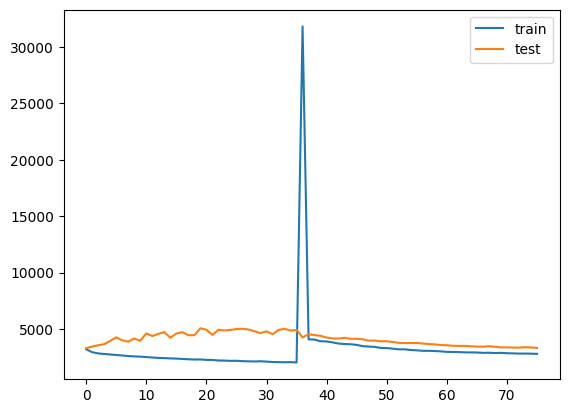

---------------------------
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 0 	Training Loss: 3035.823710
         	Testing Loss: 3336.547668
KM balanced accuracy score with hand-crafted labels :  0.5173990478473816
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1 	Training Loss: 2791.253194
         	Testing Loss: 3336.136475
KM balanced accuracy score with hand-crafted labels :  0.5861047367880261
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 2 	Training Loss: 2691.399160
         	Testing Loss: 3323.288269
KM balanced accuracy score with hand-crafted labels :  0.5731582011850533
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 3 	Training Loss: 2620.669230
         	Testing Loss: 3373.748108
KM balanced accuracy score with hand-crafted labels :  0.5746480802822207
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 4 	Training Loss: 2552.861898
         	Testing Loss: 3742.837280
KM balanced accuracy score with hand-crafted labels :  0.5739630783984656
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 5 	Training Loss: 2482.748077
         	Testing Loss: 3853.628784
KM balanced accuracy score with hand-crafted labels :  0.5741343288694044
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 6 	Training Loss: 2447.872182
         	Testing Loss: 3849.948608
KM balanced accuracy score with hand-crafted labels :  0.5696646915779018
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 7 	Training Loss: 2375.953868
         	Testing Loss: 3625.043457
KM balanced accuracy score with hand-crafted labels :  0.5728157002431756
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 8 	Training Loss: 2339.649811
         	Testing Loss: 4206.922058
KM balanced accuracy score with hand-crafted labels :  0.5827824776518136
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 9 	Training Loss: 2294.658529
         	Testing Loss: 4346.761536
KM balanced accuracy score with hand-crafted labels :  0.5800938452580744
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 10 	Training Loss: 2250.361593
         	Testing Loss: 4426.861694
KM balanced accuracy score with hand-crafted labels :  0.5798027194574785
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 11 	Training Loss: 2209.050557
         	Testing Loss: 4339.890625
KM balanced accuracy score with hand-crafted labels :  0.6072370449018735
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 12 	Training Loss: 2170.016602
         	Testing Loss: 4625.875854
KM balanced accuracy score with hand-crafted labels :  0.5661711819707504
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 13 	Training Loss: 2153.303507
         	Testing Loss: 4348.892090
KM balanced accuracy score with hand-crafted labels :  0.6083844230571633
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 14 	Training Loss: 2119.539734
         	Testing Loss: 5167.807495
KM balanced accuracy score with hand-crafted labels :  0.5809500976127684
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 15 	Training Loss: 2127.466156
         	Testing Loss: 4627.558472
KM balanced accuracy score with hand-crafted labels :  0.5972188923519539
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 16 	Training Loss: 2099.490987
         	Testing Loss: 4360.144531
KM balanced accuracy score with hand-crafted labels :  0.6161763194848786
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 17 	Training Loss: 2065.210876
         	Testing Loss: 4495.740967
KM balanced accuracy score with hand-crafted labels :  0.6329588656368805
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 18 	Training Loss: 2038.330002
         	Testing Loss: 5150.545898
KM balanced accuracy score with hand-crafted labels :  0.6121690584649108
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 19 	Training Loss: 2025.847173
         	Testing Loss: 5143.922852
KM balanced accuracy score with hand-crafted labels :  0.5792889680446621
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 20 	Training Loss: 1999.094757
         	Testing Loss: 4932.207153
KM balanced accuracy score with hand-crafted labels :  0.5907456245504675
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 21 	Training Loss: 1973.014893
         	Testing Loss: 5120.413208
KM balanced accuracy score with hand-crafted labels :  0.6226495872863651
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 22 	Training Loss: 1983.030238
         	Testing Loss: 4961.224487
KM balanced accuracy score with hand-crafted labels :  0.6068431688187143
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 23 	Training Loss: 1968.375081
         	Testing Loss: 5185.617920
KM balanced accuracy score with hand-crafted labels :  0.6189848272082747
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 24 	Training Loss: 1948.987640
         	Testing Loss: 4925.372681
KM balanced accuracy score with hand-crafted labels :  0.6206459567763811
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 25 	Training Loss: 1934.804754
         	Testing Loss: 5087.285400
KM balanced accuracy score with hand-crafted labels :  0.655358427235675
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 26 	Training Loss: 1938.962372
         	Testing Loss: 4999.761963
KM balanced accuracy score with hand-crafted labels :  0.6091893002705757
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 27 	Training Loss: 1921.277110
         	Testing Loss: 5034.872192
KM balanced accuracy score with hand-crafted labels :  0.5902318731376511
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 28 	Training Loss: 1902.218974
         	Testing Loss: 5115.176147
KM balanced accuracy score with hand-crafted labels :  0.5940678836866802
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 29 	Training Loss: 1877.176036
         	Testing Loss: 5096.215576
KM balanced accuracy score with hand-crafted labels :  0.6272904750488064
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 30 	Training Loss: 1871.637466
         	Testing Loss: 5036.033447
KM balanced accuracy score with hand-crafted labels :  0.6125115594067884
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 31 	Training Loss: 1858.163610
         	Testing Loss: 5165.159912
KM balanced accuracy score with hand-crafted labels :  0.6171524471692297
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 32 	Training Loss: 1846.025848
         	Testing Loss: 4965.849365
KM balanced accuracy score with hand-crafted labels :  0.604034661095318
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 33 	Training Loss: 1841.153000
         	Testing Loss: 5485.187012
KM balanced accuracy score with hand-crafted labels :  0.5907456245504675
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 34 	Training Loss: 1836.493805
         	Testing Loss: 5211.277954
KM balanced accuracy score with hand-crafted labels :  0.5957290132547864
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 35 	Training Loss: 1822.056702
         	Testing Loss: 5489.712402
KM balanced accuracy score with hand-crafted labels :  0.6043771620371956
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 36 	Training Loss: 50694.958537
         	Testing Loss: 4671.331299
KM balanced accuracy score with hand-crafted labels :  0.6027160324690892
------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 37 	Training Loss: 3762.442678
         	Testing Loss: 4595.325806


In [ ]:
# number of epochs to train the model
n_epochs = 75
base_lr = 0.00001

# model parameters
hidden_mlp = 128
output_dim = 128
nc = 1
n_clusters=2
batch_size = 256

def momentum_step(m, encoder, momentum_encoder):
    '''
    Momentum step (Eq (2)).
    Args:
        - m (float): momentum value. 1) m = 0 -> copy parameter of encoder to key encoder
                                      2) m = 0.999 -> momentum update of key encoder
    '''
    params_q = encoder.state_dict()
    params_k = momentum_encoder.state_dict()

    dict_params_k = dict(params_k)

    for name in params_q:
        theta_k = dict_params_k[name]
        theta_q = params_q[name].data
        dict_params_k[name].data.copy_(m * theta_k + (1 - m) * theta_q)

    momentum_encoder.load_state_dict(dict_params_k)

    return momentum_encoder

for run in range(0, 3) :
  # build model
  encoder_model = SimpleConvNet(nc, hidden_mlp, output_dim, n_clusters).float().cuda()
  teacher_encoder_model = SimpleConvNet(nc, hidden_mlp, output_dim, n_clusters).float().cuda()
  teacher_encoder_model = momentum_step(0, encoder_model, teacher_encoder_model)
  for param in teacher_encoder_model.parameters():
      param.requires_grad = False

  with torch.no_grad():
    # transform features
    encoder_model.eval()
    teacher_encoder_model.eval()
    X_test_head = []
    for img in X_test :
      img = img.reshape((32, 32))
      img = torch.tensor(img).cuda().float()[None, None,:,:]
      head_vector = teacher_encoder_model.forward(img)
      X_test_head.append(head_vector)
    X_test_head = torch.stack(X_test_head, dim=0)[:, 0]
    # transform features
    X_train_head = []
    for img in X_train :
      img = img.reshape((32, 32))
      img = torch.tensor(img).cuda().float()[None, None,:,:]
      head_vector = teacher_encoder_model.forward(img)
      X_train_head.append(head_vector)
    X_train_head = torch.stack(X_train_head, dim=0)[:, 0]

  # get positive kmeans pseudo labels : Q
  KMeans_method = SphericalKMeans(n_clusters=n_clusters).fit(X_train_head)
  y_train_kmeans = KMeans_method.predict(X_train_head)
  y_test_kmeans = KMeans_method.predict(X_test_head)
  prototypes = KMeans_method.centroids
  prototypes = nn.functional.normalize(prototypes, dim=1, p=2)

  # get y_train and y_test pseudo-labels
  y_train_kmeans_numpy = y_train_kmeans.detach().cpu().numpy()
  L2_norms = np.linalg.norm(prototypes.cpu().numpy().T[None, :, :] - X_train_head[:, :, None].cpu().numpy(), axis=1)
  Z = [np.sum(y_train_kmeans_numpy == cluster) for cluster in range(0, n_clusters)]
  temperatures = torch.tensor(
      np.array([np.sum(L2_norms[y_train_kmeans_numpy == cluster]) / (Z[i] * log(Z[i] + alpha))
                for i, cluster in enumerate(range(0, n_clusters))])).float().cuda()
  temperatures = temperatures - temperatures.mean() + temperature

  # dataloaders
  train_data = MyDataset(X_train, y_train, torch.nn.functional.one_hot(y_train_kmeans, num_classes=n_clusters))
  test_data = MyDataset(X_test, y_test, torch.nn.functional.one_hot(y_test_kmeans, num_classes=n_clusters), test=True)
  # prepare data loaders
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, drop_last=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, drop_last=True)

  print('------------------------------------------------------------------')


  # specify loss function
  optimizer = torch.optim.Adam(encoder_model.parameters(), lr=base_lr)

  train_losses = []
  test_losses = []

  # launch training
  for epoch in range(0, n_epochs+1):
      # monitor training loss
      train_loss = 0.0
      test_loss = 0.0

      ###################
      # train the model #
      ###################
      encoder_model.train()
      for it, data in enumerate(train_loader):
          # _ stands in for labels, here no need to flatten images
          images_i, images_j, labels, pseudo_labels = data
          # forward pass: compute predicted outputs by passing inputs to the model
          latent_vectors_i = encoder_model.forward(images_i.float())
          latent_vectors_j = encoder_model.forward(images_j.float())
          # calculate the loss
          if epoch > 35:
            loss = PCLLoss(latent_vectors_i, latent_vectors_j, prototypes, pseudo_labels, temperatures)
          else :
            loss = NTXentLoss(latent_vectors_i, latent_vectors_j)
          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # perform a single optimization step (parameter update)
          optimizer.step()
          # update running training loss
          train_loss += loss.item()*images_i.size(0)
          # clear the gradients of all optimized variables
          optimizer.zero_grad()

      if epoch <= 35:
          teacher_encoder_model = momentum_step(0, encoder_model, teacher_encoder_model)
      else:
          teacher_encoder_model = momentum_step(0.99, encoder_model, teacher_encoder_model)

      ###################
      # evaluate the model #
      ###################
      encoder_model.eval()
      with torch.no_grad():
        for data in test_loader:
          # _ stands in for labels, here no need to flatten images
          images_i, images_j, labels, pseudo_labels = data
          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          # forward pass: compute predicted outputs by passing inputs to the model
          latent_vectors_i = encoder_model.forward(images_i.float())
          latent_vectors_j = encoder_model.forward(images_j.float())
          # calculate the loss
          if epoch > 35:
            loss = PCLLoss(latent_vectors_i, latent_vectors_j, prototypes, pseudo_labels, temperatures)
          else :
            loss = NTXentLoss(latent_vectors_i, latent_vectors_j)
          # update running testing loss
          test_loss += loss.item()*images_i.size(0)

      # print avg training statistics
      train_loss = train_loss/len(train_loader)
      test_loss = test_loss/len(test_loader)
      #
      train_losses.append(train_loss)
      test_losses.append(test_loss)
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(
          epoch,
          train_loss
          ))
      print('         \tTesting Loss: {:.6f}'.format(
          test_loss
          ))

      with torch.no_grad():
        # transform features
        encoder_model.eval()
        teacher_encoder_model.eval()
        X_test_head = []
        for img in X_test :
          img = img.reshape((32, 32))
          img = torch.tensor(img).cuda().float()[None, None,:,:]
          head_vector = teacher_encoder_model.forward(img.float())
          X_test_head.append(head_vector)
        X_test_head = torch.stack(X_test_head, dim=0)[:, 0]
        # transform features
        X_train_head = []
        for img in X_train :
          img = img.reshape((32, 32))
          img = torch.tensor(img).cuda().float()[None, None,:,:]
          head_vector = teacher_encoder_model.forward(img.float())
          X_train_head.append(head_vector)
        X_train_head = torch.stack(X_train_head, dim=0)[:, 0]

      # get positive kmeans pseudo labels : Q
      KMeans_method = SphericalKMeans(n_clusters=n_clusters).fit(X_train_head)
      y_train_kmeans = KMeans_method.predict(X_train_head)
      y_test_kmeans = KMeans_method.predict(X_test_head)
      prototypes = KMeans_method.centroids
      prototypes = nn.functional.normalize(prototypes, dim=1, p=2)

      # get y_train and y_test pseudo-labels
      y_train_kmeans_numpy = y_train_kmeans.detach().cpu().numpy()
      L2_norms = np.linalg.norm(prototypes.cpu().numpy().T[None, :, :] - X_train_head[:, :, None].cpu().numpy(), axis=1)
      Z = [np.sum(y_train_kmeans_numpy == cluster) for cluster in range(0, n_clusters)]
      temperatures = torch.tensor(
          np.array([np.sum(L2_norms[y_train_kmeans_numpy == cluster]) / (Z[i] * log(Z[i] + alpha))
                    for i, cluster in enumerate(range(0, n_clusters))])).float().cuda()
      temperatures = temperatures - temperatures.mean() + temperature

      # dataloaders
      train_data = MyDataset(X_train, y_train, y_train_kmeans)
      test_data = MyDataset(X_test, y_test, y_test_kmeans, test=True)
      # prepare data loaders
      train_data = MyDataset(X_train, y_train, torch.nn.functional.one_hot(y_train_kmeans, num_classes=n_clusters))
      test_data = MyDataset(X_test, y_test, torch.nn.functional.one_hot(y_test_kmeans, num_classes=n_clusters), test=True)

      print("KM balanced accuracy score with hand-crafted labels : ",
                  max(balanced_accuracy_score(y_cluster_test, y_test_kmeans.detach().cpu().numpy()[:len(y_cluster_test)]),
                  balanced_accuracy_score(1-y_cluster_test, y_test_kmeans.detach().cpu().numpy()[:len(y_cluster_test)]))
                  )

      print('------------------------------------------------------------------')

  plt.plot(train_losses, label="train")
  plt.plot(test_losses, label="test")
  plt.legend()
  plt.show()


  print('---------------------------')

In [ ]:
pcl_normal = []
pcl_morpho = [0.6644, ]